# Base Notebook Delivery Apps Review Classification

# Imports, Global Variables and Downloads

Transformers es la libreria que nos permite usar BERT


nlpaug data augmentation

In [1]:
!pip install transformers
!pip install nlpaug

In [2]:
import transformers
import torch

from google.colab import files

from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nlpaug.augmenter.word as naw

from collections import defaultdict

from torch import nn

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils import data

BERT_HUGGINGFACE_PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'

MAX_LEN = 70
BATCH_SIZE = 64 # 8 16 32 64 128 256
EPOCHS = 4
RANDOM_SEED = 42
TARGET_CLASS = 'Support'
DOWNLOAD_MODEL = False

Downloading dataset

In [3]:
!gdown --id 16HheP0nKEJCxzsIE3jbWvt8Xz-pmtuuI --output review_dataset.csv

Downloading...
From: https://drive.google.com/uc?id=16HheP0nKEJCxzsIE3jbWvt8Xz-pmtuuI
To: /content/review_dataset.csv
100% 247k/247k [00:00<00:00, 39.6MB/s]


Downloading fasttext spanish word embedding for data augmentation

In [4]:
!gdown --id 1ytY_Pr1XUy9v5abbOxBIHdcZ0GMJl1M2 --output fasttext-sbwc.vec

Downloading...
From: https://drive.google.com/uc?id=1ytY_Pr1XUy9v5abbOxBIHdcZ0GMJl1M2
To: /content/fasttext-sbwc.vec
2.24GB [00:25, 87.1MB/s]


Si no aparece la nvidia hay que ir a Runtime > Change Runtime type > GPU

In [5]:
!nvidia-smi

Tue Oct 20 03:05:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# Choose dataset and classification target

In [7]:
def get_dataset_dataset(file, columns, index, convert2int64, naval=-1, preview=False):
    """Carga el csv de file
    Completa las columnas con los valores requeridos
    Pasa todos los valores numericos a int64.
    Vuela el doble Index
    Vuela todos los NaN: Poner el numero 'naval' para los valores null """
    df = pd.read_csv(file, names=columns)
    df.set_index(index, inplace=True)

    for col in convert2int64:
        df[col] = df[col].fillna(naval)
        df[col] = df[col].astype(np.float64)
    
    if preview:
        print(df.head())
        print('\n', "-------------------------", '\n')
        print(df.info())
    
    return df

df = get_dataset_dataset(
    "review_dataset.csv",
    ["Index", "Content", "Sentiment", "App", "Service", "Support"],
    'Index',
    convert2int64=['Sentiment', 'App', "Service", "Support"],
    preview=True
)

                                  Content  Sentiment  App  Service  Support
Index                                                                      
2094                Agilidad y protocolos        2.0 -1.0      2.0     -1.0
474                              Exelente        2.0  2.0     -1.0     -1.0
874       Muy buena recepcion de producto        2.0 -1.0      2.0     -1.0
189    Se queda en negro al querer entrar        0.0  0.0     -1.0     -1.0
1976                          son lindos!        2.0 -1.0     -1.0     -1.0

 ------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 2094 to 1352
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Content    2150 non-null   object 
 1   Sentiment  2150 non-null   float64
 2   App        2150 non-null   float64
 3   Service    2150 non-null   float64
 4   Support    2150 non-null   float64
dtypes: float64(4), object(1)
memory usage: 100.8

In [8]:
def get_dataset_for_classification(df, clase, binarize=True, binval=-1, preview=False):
    """Returns the dataframe with its content and a specific class for posteriori classification
    If binarize is set to True, it returns the class binabinarized_service_df.head()
    binarized_service_df.info()rized, mapping binval to 0 and other to 1
    """

    new_df = df[['Content', clase]].copy()

    if binarize:
        new_df[clase] = new_df[clase].apply(lambda x: 0 if x == binval else 1)

    if preview:
        print(new_df.head())
        print('\n', "-" * 40, '\n')
        print(new_df.info())

    return new_df

binarized_class_df = get_dataset_for_classification(df, TARGET_CLASS, preview=True)

                                  Content  Support
Index                                             
2094                Agilidad y protocolos        0
474                              Exelente        0
874       Muy buena recepcion de producto        0
189    Se queda en negro al querer entrar        0
1976                          son lindos!        0

 ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 2094 to 1352
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  2150 non-null   object
 1   Support  2150 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.4+ KB
None


# Data analysis

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


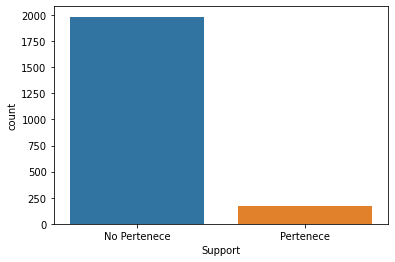

In [9]:
ax = sns.countplot(binarized_class_df[TARGET_CLASS])
plt.xlabel(f'{TARGET_CLASS}')
ax.set_xticklabels(['No Pertenece', 'Pertenece']);

# Text Preprocessing

In [10]:
tokenizer = transformers.BertTokenizer.from_pretrained(BERT_HUGGINGFACE_PRE_TRAINED_MODEL_NAME)

if DOWNLOAD_MODEL:
    # Fijarme si n ohay un downlaod folder
    tokenizer.save_pretrained('tokenizer_state')
    files.download('tokenizer_state/special_tokens_map.json')
    files.download('tokenizer_state/tokenizer_config.json')
    files.download('tokenizer_state/vocab.txt')    

# Creating Torch Dataset

In [11]:
class GPReviewDataset(data.Dataset):
    """https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset"""

    def __init__(self, review, target, tokenizer, max_len):
        self.review = review # Contenido
        self.target = target # Clase
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])

        encoding = tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.long),
        }

In [12]:
df_train, df_test = train_test_split(binarized_class_df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(binarized_class_df, test_size=0.5, random_state=RANDOM_SEED)

# Data Augmentation: Word Embedding Agumenter

Esto puede llevar como 6 minutos

In [13]:
SKIP_STEP_DAWEA = False

In [14]:
def augment_df_with_nlpaug(df, content, target, aug_p=0.25, df_p=0.2, test_fun=False):
    """Augments the content of the dataset with similar words but retaining the target.
    :df: Dataframe to agument
    :content: column to agument
    :target: column target
    :bert_model: path to the pre trained bert model to use, default is set to hugging face transformer library
    :aug_p: probability of changing a word
    :df_p: probability to augment the row. 1 Augments all the dataset duplicating it.
    returns a shuffled dataset with the new rows

    https://github.com/makcedward/nlpaug/blob/master/example/textual_language_augmenter.ipynb
    """
    df = df.copy()

    aug = naw.WordEmbsAug(model_type='fasttext',
                    model_path="fasttext-sbwc.vec", aug_min=2, aug_p=aug_p, aug_max=35)


    for _, row in tqdm(df.iterrows()):
        if test_fun:
            print({
                content: aug.augment(row[content]),
                # Capaz a esto se le puede agregar algo que lo lleve al infinitivo
                target: row[target]
            })
            break
        if np.random.random() < df_p: 
            df = df.append({
                content: aug.augment(row[content]),
                target: row[target]
            }, ignore_index=True)

    return shuffle(df)

In [15]:
if not SKIP_STEP_DAWEA:
    df_train = augment_df_with_nlpaug(
        df_train,
        content='Content',
        target=TARGET_CLASS,
        test_fun=False # True, devuelve el primer comentario del df augmentado para poder observar
        )

1720it [05:49,  4.92it/s]


# Data Augmentation: Concatenate Comments

La idea que puede servir para augmentar es concatenar comentarios de clases distintas para que el modelo entienda que cuando un comentario habla de muchas clases, tambien pertenece a la que uno esta analizando

Si estamos teniendo en cuenta el sentimiento es MUY importante que no hagamos este step de pre procesamiento porque podria concatenar comentarios positivos y negativos de la misma clase y pifiarla heavy

In [16]:
SKIP_STEP_DACC = False

In [17]:
def random_comment_concat(df, target, nanval=0, concat_prob=0.3, test_fun=False):
    df = df.copy()
    prev_comment = None
    for _, row in tqdm(df.iterrows()):
        if (np.random.random() < concat_prob and prev_comment is not None):
            
            if test_fun:
                print(f'Actual comment: {row["Content"]}')
                print(f'Previous comment: {prev_comment}')
            
            new_comment = row['Content'] + ' ' + prev_comment
            
            if test_fun:
                print(f'New comment: {new_comment}')
                print()
                print(f'Actual target: {row[target]}')
                print(f'Previous target: {prev_target}')
                print(f'New target: {row[target] or prev_target}')
                break
            
            df = df.append({
                'Content': new_comment,
                target: row[target] or prev_target
            }, ignore_index=True)

        prev_comment = row['Content']
        prev_target = row[target]

    return shuffle(df)

In [18]:
if not SKIP_STEP_DACC:
    df_train = random_comment_concat(df_train, target=TARGET_CLASS, test_fun=False)

2094it [00:01, 1200.61it/s]


# Shapes

In [19]:
df_train.shape, df_val.shape, df_test.shape

((2734, 2), (1075, 2), (1075, 2))

# Create Data Loader

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        review=df['Content'].to_numpy(),
        target=df[TARGET_CLASS].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

print(len(val_data_loader) * BATCH_SIZE)
print(len(df_val[TARGET_CLASS]))

data_batch = next(iter(train_data_loader)) # Returns a batch
print("BATCH CHECK")
print("-" * 40)
print("Batch keys:")
print(data_batch.keys())
print("-" * 40)
print("Batch input")
print(data_batch['input_ids'])
print("-" * 40)
print("Batch Targets")
print(data_batch['targets'])

1088
1075
BATCH CHECK
----------------------------------------
Batch keys:
dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
----------------------------------------
Batch input
tensor([[    4,  5869,  2799,  ...,     1,     1,     1],
        [    4,  1125,  1058,  ...,     1,     1,     1],
        [    4,  1339, 18545,  ...,  1084,  1240,     5],
        ...,
        [    4, 22330,  1036,  ...,     1,     1,     1],
        [    4,  1552, 11072,  ...,     1,     1,     1],
        [    4,  3624,  1040,  ...,     1,     1,     1]])
----------------------------------------
Batch Targets
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])


# Building Classifier

In [21]:
class ReviewClassifier(nn.Module):

    def __init__(self, n_classes):
        super(ReviewClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_HUGGINGFACE_PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # = Dense en keras
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)

        return self.sigmoid(self.out(output))

In [22]:
BINARY = 1
model = ReviewClassifier(BINARY)
model = model.to(device)
print(model)

ReviewClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

# Training

In [23]:
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=False) # based in BERT paper

total_steps = len(train_data_loader) * EPOCHS # BATCH * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)
loss_fn.requres_grad = True

In [24]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader): # tqdm permite trackear visualmente el proceso
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        outputs = outputs.flatten() # esto es la salida de la sigmoidea
        loss = loss_fn(outputs, targets.float())

        # PREDICTIONS 
        pred = torch.round(outputs) # redondeo crudo         
        
        correct_predictions += torch.sum(pred == targets)
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # If gradients are to large, the training is unstable, so gradient clipping fixes this
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        outputs = outputs.flatten()
        loss = loss_fn(outputs, targets.float())

        # PREDICTIONS 
        pred = torch.round(outputs)        
        
        correct_predictions += torch.sum(pred == targets)

        losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print()
    print()
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print()

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_data_loader) * BATCH_SIZE
    )

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_data_loader) * BATCH_SIZE
    )

    print()
    print(f'Train   loss {train_loss} accuracy {train_acc}')
    print(f'Val     loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), f'{TARGET_CLASS}_model.bin')
        best_accuracy = val_acc

  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 1/4
----------



100%|██████████| 17/17 [00:04<00:00,  3.69it/s]



Train   loss 0.284825399777917 accuracy 0.8873546511627907
Val     loss 0.11767029039123479 accuracy 0.9411764705882353



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 2/4
----------



100%|██████████| 17/17 [00:04<00:00,  3.60it/s]



Train   loss 0.10927284127751062 accuracy 0.9553052325581395
Val     loss 0.05982332895783817 accuracy 0.9650735294117647



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 3/4
----------



100%|██████████| 17/17 [00:04<00:00,  3.58it/s]



Train   loss 0.031648536721720945 accuracy 0.9832848837209303
Val     loss 0.009076046127387705 accuracy 0.9852941176470588



  0%|          | 0/43 [00:00<?, ?it/s]



Epoch 4/4
----------



100%|██████████| 17/17 [00:04<00:00,  3.66it/s]



Train   loss 0.012160231294327004 accuracy 0.9905523255813954
Val     loss 0.005913445185048177 accuracy 0.9862132352941176

CPU times: user 1min 21s, sys: 1min, total: 2min 22s
Wall time: 2min 28s


Download del modelo, aprox 450 MB tarda 14 min

In [27]:
if DOWNLOAD_MODEL:
    files.download(f'{TARGET_CLASS}_model.bin')

# Evaluation

In [28]:
def get_reviews(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.round(outputs)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [29]:
model = ReviewClassifier(BINARY)
model.load_state_dict(torch.load(f'{TARGET_CLASS}_model.bin'))
model = model.to(device)

In [30]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


In [31]:
print(test_acc)

tensor(0.9693, device='cuda:0', dtype=torch.float64)


In [32]:
y_review_texts, y_pred, y_pred_probs, y_test = get_reviews(model, test_data_loader)

In [33]:
print(classification_report(y_test, y_pred, target_names=[f'Not {TARGET_CLASS}', f'{TARGET_CLASS}']))

              precision    recall  f1-score   support

 Not Support       0.99      0.98      0.98       996
     Support       0.77      0.82      0.80        79

    accuracy                           0.97      1075
   macro avg       0.88      0.90      0.89      1075
weighted avg       0.97      0.97      0.97      1075



In [34]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

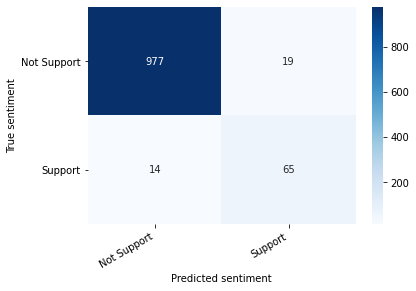

In [35]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[f'Not {TARGET_CLASS}', f'{TARGET_CLASS}'], columns=[f'Not {TARGET_CLASS}', f'{TARGET_CLASS}'])
show_confusion_matrix(df_cm)

# Prueba Real

In [38]:
review_text = """Me intente comunicar para pedir ayuda un monton de veces y nunca me pudieron dar una solucion, pesimo!
"""

# review_text = "Atención al cliente es un curro nunca te resuelven nada"

encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
print(f'Prediction value: {output.tolist()[0][0]}')
prediction = torch.round(output)

clases = [f'Not {TARGET_CLASS}', f'{TARGET_CLASS}']

print(f'Review text: {review_text}')
print(f'Review text length: {len(tokenizer.tokenize(review_text))}')
print(f'Category: {clases[int(prediction.tolist()[0][0])]}')

Prediction value: 0.9958082437515259
Review text: Me intente comunicar para pedir ayuda un monton de veces y nunca me pudieron dar una solucion, pesimo!

Review text length: 22
Category: Support
